### Build a Perfect FeatsNet

In [2]:
import os, sys
import copy as copyroot
import pandas as pd
import torch
from IPython.display import display
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from fastai2.basics import *
from fastai2.vision.all import *
%load_ext autoreload
%autoreload 2
from module.mnist_helpers import build_df, eda_fig_1, build_dls
from module.mnist_models import FeatsNet
from module.mnist_metrics import metrics_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setup

In [3]:
dls_tl = build_dls(target='topleft')
dls_cr = build_dls(target='center')

In [4]:
path = untar_data(URLs.MNIST_TINY)
df = build_df(path)

In [5]:
# df2 - pixel values
df2 = pd.DataFrame([])
for i, row in df.iterrows():    
    img_np = np.array(Image.open(str(path) + row['fn']))
    df2 = pd.concat((df2, pd.Series(img_np.flatten())), axis=1)
df2 = df2.T
df2.reset_index(inplace=True, drop=True)

In [6]:
# df3 - pts features

feats = ['pts11','pts12','pts22']
featsnet = FeatsNet(feats = feats)

# 2*(4 + 16 + 16)
cols =  []
cols += [f'pts11_{i}' for i in range(8)]
cols += [f'pts12_{i}' for i in range(32)]
cols += [f'pts22_{i}' for i in range(32)]

df3 = pd.DataFrame([])
for i, row in df.iterrows():    
    img_np = np.array(Image.open(str(path) + row['fn']))
    tmp = featsnet.build_feats(
                torch.tensor(img_np).unsqueeze(0)
                ).squeeze(0).tolist()
    df3 = pd.concat((df3, pd.Series(tmp)), axis=1)
df3 = df3.T
df3.reset_index(inplace=True, drop=True)
df3.columns = cols

In [7]:
y_names = ['scalar_pxsum', 'point_topleft_x', 'point_topleft_y',
          'point_center_x', 'point_center_y']

df2_y = df[y_names]
df2 = pd.concat((df2, df3, df2_y), axis=1)

df2.head(2)

,0,1,2,3,4,5,6,7,8,9,...,pts22_27,pts22_28,pts22_29,pts22_30,pts22_31,scalar_pxsum,point_topleft_x,point_topleft_y,point_center_x,point_center_y
0,0,0,0,0,0,0,0,0,0,0,...,0.428571,0.214286,0.392857,0.214286,0.214286,35867,11,5,15,14
1,0,0,0,0,0,0,0,0,0,0,...,0.607143,0.642857,0.321429,0.642857,0.464286,29717,9,4,14,13


In [8]:
y_cols = y_names
x_cols = [col for col in df2.columns if col not in y_cols]

X = df2[x_cols]
Y = df2[y_cols]

y_tlx, y_tly, y_crx, y_cry = [Y.iloc[:,i] for i in range(1,5)]

Xt, Xv, yt_tlx, yv_tlx = train_test_split(X,  y_tlx, random_state=0)
_,  _,  yt_tly, yv_tly = train_test_split(X,  y_tly, random_state=0)
_,  _,  yt_crx, yv_crx = train_test_split(X,  y_crx, random_state=0)
_,  _,  yt_cry, yv_cry = train_test_split(X,  y_cry, random_state=0)

### Setup Tabular Dls

In [78]:
from fastai2.tabular.all import *

In [79]:
data = pd.concat((X, y_tlx, y_tly), axis=1)

In [80]:
y_tmp = y_tlx.copy()
y_tmp = (y_tmp - 14) / 14
y_tmp2 = y_tly.copy()
y_tmp2 = (y_tmp2 -14) / 14

pts_cols = [e for e in X.columns if 'pts' in str(e)]

In [86]:
data = pd.concat((X.loc[:, pts_cols], y_tmp, y_tmp2), axis=1)

In [87]:
print(data.shape)
data.head(2)

(709, 74)


,pts11_0,pts11_1,pts11_2,pts11_3,pts11_4,pts11_5,pts11_6,pts11_7,pts12_0,pts12_1,...,pts22_24,pts22_25,pts22_26,pts22_27,pts22_28,pts22_29,pts22_30,pts22_31,point_topleft_x,point_topleft_y
0,0.178571,0.178571,0.178571,0.785714,0.857143,0.178571,0.857143,0.785714,0.178571,0.75,...,0.214286,0.75,0.214286,0.428571,0.214286,0.392857,0.214286,0.214286,-0.214286,-0.642857
1,0.142857,0.250000,0.142857,0.678571,0.821429,0.250000,0.821429,0.678571,0.142857,0.50,...,0.642857,0.50,0.642857,0.607143,0.642857,0.321429,0.642857,0.464286,-0.357143,-0.714286


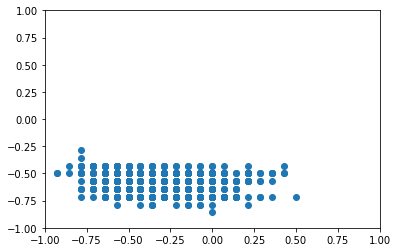

In [85]:
plt.scatter(y_tmp, y_tmp2);
plt.xlim(-1,1); plt.ylim(-1,1);

In [88]:
dls = TabularDataLoaders.from_df(data, 
                                 path='.', 
                                 y_names=['point_topleft_x',
                                          'point_topleft_y'],
#                                  y_names='point_topleft_x', 
                                 procs=[Normalize])


In [89]:
ret = dls.one_batch()

In [90]:
ret[0].shape, ret[1].shape, ret[2].shape

(torch.Size([64, 0]), torch.Size([64, 72]), torch.Size([64, 2]))

In [91]:
ret[1].min()

tensor(-2.8755)

### Learner

In [99]:
learn = tabular_learner(dls,)

In [100]:
learn.loss_func

FlattenedLoss of MSELoss()

In [101]:
# learn.lr_find()

In [102]:
learn.fit_one_cycle(90)

epoch,train_loss,valid_loss,time
0,0.598110,0.415164,00:00
1,0.560356,0.406201,00:00
2,0.518282,0.373002,00:00
3,0.469642,0.305066,00:00
4,0.416219,0.220806,00:00
5,0.358860,0.137640,00:00
6,0.302041,0.072558,00:00
7,0.249443,0.034533,00:00
8,0.205473,0.021399,00:00
9,0.170904,0.016287,00:00


##### metrics, ultimately not as good as FeatsNet

In [103]:
metrics_df(learn,"","","")

,model,details,target,split,mse,mae,r2,dist_avg,dist_r2,sqdist_avg,sqdist_r2
0,,,,valid,0.001485,0.028503,0.907186,0.044212,0.793423,0.002970,0.953105
1,,,,train,0.000215,0.011746,0.987557,0.018440,0.921691,0.000429,0.994360


##### verify this can be fit with linear model better

In [112]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [114]:
x_cols = [e for e in data.columns if 'pts' in e]
Xlr = data.loc[:,x_cols]
ylr = data['point_topleft_x']

Xlr_t, Xlr_v, ylr_t, ylr_v = train_test_split(Xlr, ylr)

In [119]:
lr = LinearRegression()

lr.fit(Xlr_t, ylr_t)

lr.score(Xlr_t, ylr_t), lr.score(Xlr_v, ylr_v)

(0.9999999999999952, 0.9999999999999957)

In [120]:
lr.coef_

array([ -142522.62246844,  -976204.53911642,   452121.40998697,
       -1116060.81663279,   422586.68157864,   830883.33337236,
       -3103664.57548117,  1574454.8400496 ,  -556921.62841502,
        -219862.46159789,  -993148.87661607,   656627.37319944,
         379346.53066882,   -83535.51599819,   861125.18684382,
        1632714.43433023,  2421571.97772496,    43972.49231958,
        -215072.52242738,  -131325.47463988,  -215072.52242738,
          16707.50319965,   689650.96103233,  -313848.30638509,
        2296862.70315185,    36330.30143602,  -165061.28570878,
        -318449.68005783,    22917.42325429,    36330.30143602,
        -293469.98724647,    89252.66834942,   456458.2955619 ,
          36330.30143602,    -8557.91040345,  -318449.68005783,
         427069.35860509,    36330.30143602,  -220572.72573693,
          89252.66834942,  -847738.02981983,    43972.49231958,
        -847738.02981983,  -131325.47463988,  -847738.02981983,
          16707.50319965,   411412.67201

In [121]:
lr = Ridge()

lr.fit(Xlr_t, ylr_t)

lr.score(Xlr_t, ylr_t), lr.score(Xlr_v, ylr_v)

(0.9994666825543455, 0.9994259451579021)

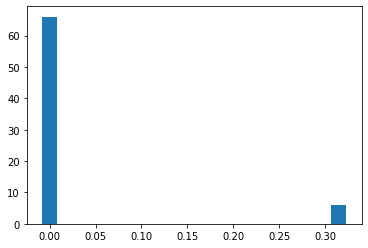

In [124]:
plt.hist(lr.coef_, bins=20);

<BarContainer object of 72 artists>

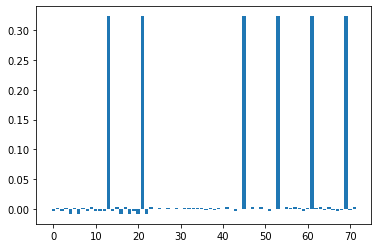

In [128]:
plt.bar(range(len(lr.coef_)), lr.coef_)

In [129]:
lr = Lasso()

lr.fit(Xlr_t, ylr_t, )

lr.score(Xlr_t, ylr_t), lr.score(Xlr_v, ylr_v)

(0.0, -0.00021556242555598182)

In [131]:
lr.coef_.min(), lr.coef_.max()

(-0.0, -0.0)

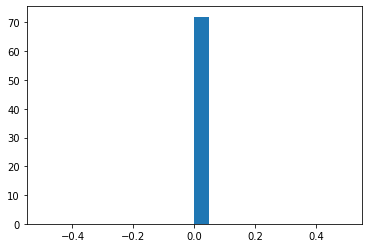

In [130]:
plt.hist(lr.coef_, bins=20);